<a href="https://colab.research.google.com/github/LokeRuiKee/AChE-GNN/blob/main/DC_GraphConvModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install rdkit
!pip install colorama
!pip install deepchem

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset: Load, Split, Featurize

In [4]:
import pandas as pd
import deepchem as dc
from sklearn.model_selection import train_test_split
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Load the dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/Dataset/tx2c00283_si_002/SupplementalFiles/Human_dataset_1micromolar.xlsx"
df = pd.read_excel(file_path)

# Specify the columns
smiles_column = "SMILES"
y_column = "single-class-label"

# Split the data into features and target
X = df[smiles_column]
y = df[y_column]

# Split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Concatenate the features and target for each set
train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Define the directory and file paths
base_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/data/process"
train_file = os.path.join(base_dir, "pdY_train.csv")
val_file = os.path.join(base_dir, "pdY_val.csv")
test_file = os.path.join(base_dir, "pdY_test.csv")

# Create the directory if it doesn't exist
os.makedirs(base_dir, exist_ok=True)

# Save the data to CSV files
train_data.to_csv(train_file, index=False)
val_data.to_csv(val_file, index=False)
test_data.to_csv(test_file, index=False)

# Load the data using DeepChem
tasks = ["single-class-label"]
ntasks = len(tasks)
featurizer_func = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field='SMILES', featurizer=featurizer_func)

train_dataset = loader.create_dataset(train_file)
val_dataset = loader.create_dataset(val_file)
test_dataset = loader.create_dataset(test_file)

# Model Construction

## Model 1 graph_conv_layers = [64, 64, 64], dense_layer_size=128, dropout=0

Classification mode of DeepChem's GraphConvModel. Completion of Model 1 date: 3/6/2024

In [10]:
batch_size = 64
batches_per_epoch = 600/batch_size
learning_rate = dc.models.optimizers.ExponentialDecay(0.0001, 0.9, batches_per_epoch)

model = dc.models.GraphConvModel(ntasks,
                                 graph_conv_layers=[64, 64, 64],
                                 dense_layer_size=128,
                                 dropout=0.,
                                 batch_normalize=True,
                                 mode='classification',
                                 batch_size=batch_size,
                                 learning_rate=learning_rate,
                                 model_dir='/content/drive/MyDrive/Colab Notebooks/FYP1/DeepChemGCNModels')
model.fit(train_dataset)
model.save_checkpoint()

metrics = [dc.metrics.Metric(dc.metrics.accuracy_score),
           dc.metrics.Metric(dc.metrics.f1_score),
           dc.metrics.Metric(dc.metrics.roc_auc_score)]

for metric in metrics:
    print("Train", metric.name, ":", model.evaluate(train_dataset, [metric]))
    print("Test", metric.name, ":", model.evaluate(test_dataset, [metric]))

Train accuracy_score : {'accuracy_score': 0.7832310838445807}
Test accuracy_score : {'accuracy_score': 0.7484662576687117}
Train f1_score : {'f1_score': 0.7663139329805997}
Test f1_score : {'f1_score': 0.7496947496947497}
Train roc_auc_score : {'roc_auc_score': 0.8593345580730762}
Test roc_auc_score : {'roc_auc_score': 0.8255188548412382}


Result 3/6/2024
- Train accuracy_score : {'accuracy_score': 0.7832310838445807}
- Test accuracy_score : {'accuracy_score': 0.7484662576687117}
- Train f1_score : {'f1_score': 0.7663139329805997}
- Test f1_score : {'f1_score': 0.7496947496947497}
- Train roc_auc_score : {'roc_auc_score': 0.8593345580730762}
- Test roc_auc_score : {'roc_auc_score': 0.8255188548412382}

### Inference

In [22]:
# Test case for class 0

# Define a new SMILES string
new_smiles = "Nc1c2c(nc3c1CCC3)CCCC2"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.33675307 0.6632469 ]
Predicted class for new data: 1


In [14]:
# Test case for class 0

# Define a new SMILES string
new_smiles = "Cc1ccc(OP(=O)(N(C)C)N2CCOCC2)cc1"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.75419796 0.24580204]
Predicted class for new data: 0


In [15]:
# Test case for class 1

# Define a new SMILES string
new_smiles = "COc1ccc2nc(NCCc3cc[n+](Cc4ccccc4)cc3)sc2c1"

# Create a ConvMolFeaturizer
featurizer = dc.feat.ConvMolFeaturizer()

# Convert the SMILES string to the format expected by the model
new_mol = Chem.MolFromSmiles(new_smiles)
new_data = featurizer.featurize([new_mol])

# Create a Dataset object from the new data
new_dataset = dc.data.NumpyDataset(new_data)

# Predict the class probabilities for the new data
new_pred_probs = model.predict(new_dataset)

# Select the probabilities of the first task
new_pred_probs = new_pred_probs[:, 0]

# Convert the predicted probabilities to class labels
new_preds = np.argmax(new_pred_probs, axis=1)

print("Predicted probs for new data:", new_pred_probs[0])
print("Predicted class for new data:", new_preds[0])

Predicted probs for new data: [0.37005165 0.6299484 ]
Predicted class for new data: 1


In [33]:
# Test case with test dataset

# Get the predicted probabilities
pred_probs = model.predict(test_dataset)

# Select the probabilities of the first task
pred_probs = pred_probs[:, 0]

# Convert the predicted probabilities to class labels
preds = np.argmax(pred_probs, axis=1)

print("Test dataset: ", test_dataset)
print("Predicted probabilities: ", pred_probs)
print("Predicted class: ", preds)

Test dataset:  <DiskDataset X.shape: (815,), y.shape: (815, 1), w.shape: (815, 1), ids: ['Nc1c2c(nc3c1CCC3)CCCC2' 'COc1cc2[se]n(-c3ccc(CN4CCCCC4)cc3)c(=O)c2cc1OC'
 'COc1cc2c(cc1O)CCC(C)(CCC(=O)NCCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2' ...
 'COc1cc2c(cc1OC)CN(CC1CCN(Cc3cc(Br)cc(/C=N/O)c3O)CC1)CC2'
 'O=[N+]([O-])c1ccc2nc3c(c(NCc4ccccc4)c2c1)CCCC3'
 'NC(=O)c1sc(-c2ccnc(NC(=O)C3CC3)c2)nc1OCCCC1CCN(Cc2ccccc2F)CC1'], task_names: ['single-class-label']>
Predicted probabilities:  [[0.33675304 0.66324687]
 [0.5754449  0.4245551 ]
 [0.04426827 0.9557316 ]
 ...
 [0.6626042  0.33739573]
 [0.39582223 0.6041778 ]
 [0.43885875 0.56114125]]
Predicted class:  [1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0
 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1
 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1
 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0

# Optional (Just for understanding)

## Visualize the use of ConvMolFeaturizer

Featurize the Data: Convert the SMILES strings into graph-based features using the ConvMolFeaturizer.

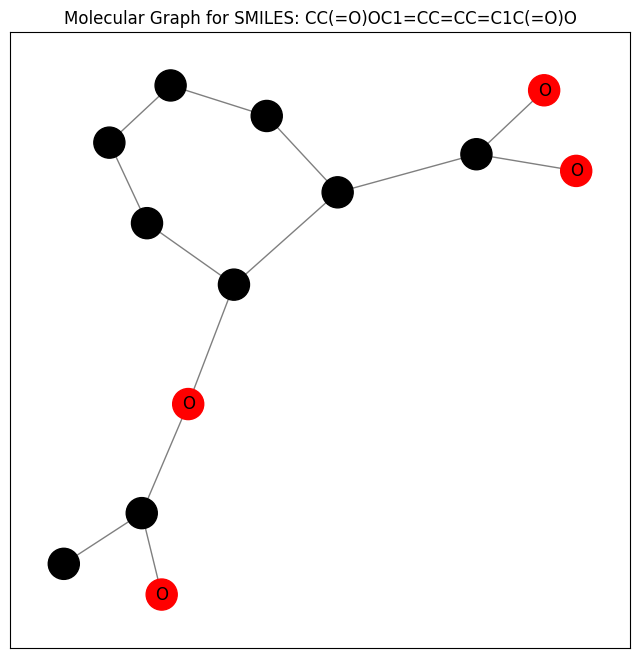

In [17]:
# Visualize the use of ConvMolFeaturizer

from deepchem.feat import ConvMolFeaturizer
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt

# Example SMILES string
smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'

# Featurize the SMILES string
featurizer = ConvMolFeaturizer()
mol_features = featurizer.featurize([smiles])[0]

# Extract the molecule
rdkit_mol = Chem.MolFromSmiles(smiles)

# Create a NetworkX graph from RDKit molecule
G = nx.Graph()
for atom in rdkit_mol.GetAtoms():
    G.add_node(atom.GetIdx(), label=atom.GetSymbol())

for bond in rdkit_mol.GetBonds():
    G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), order=bond.GetBondType())

# Define a color map for atoms (optional)
atom_colors = {
    'H': 'white',
    'C': 'black',
    'O': 'red',
    'N': 'blue',
    'S': 'yellow',
    'F': 'green',
    'Cl': 'green',
    'Br': 'brown',
    'I': 'purple'
}

# Get atom symbols for coloring
colors = [atom_colors[rdkit_mol.GetAtomWithIdx(i).GetSymbol()] for i in G.nodes()]

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, {i: rdkit_mol.GetAtomWithIdx(i).GetSymbol() for i in G.nodes()})
plt.title("Molecular Graph for SMILES: {}".format(smiles))
plt.show()